In [5]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pandas as pd
from typing import *
import numpy as np
from itertools import product

# Data

In [6]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i_l = 17.417  # initial level
i_t = 0.465  # initial trend
i_s_mul = [1.09, 1.09, 1.32, 0.97, 1.03, 0.57, 0.63, 1.20, 1.72, 1.43, 0.51, 0.40]
i_s_add = [1.58, 1.58, 5.58, -0.41, 0.58, -7.41, -6.41, 3.58, 12.58, 7.58, -8.41, -10.41]

# Load and preprocess
df = pd.read_csv("data/sales.csv", parse_dates=["date"])
df = df.set_index("date")
df = df.asfreq("MS")

df_train = df[:-12]
df_test = df[-12:]

# Use the Series, not flattened NumPy array
df_train_one_d = df_train["quantity"]
df_test_one_d = df_test["quantity"]

# Define options for each component
errors = ["add", "mul"]
trends = [None, "add", "mul"]
seasonals = [None, "add", "mul"]
dampeds = [False, True]

# List to store valid configurations
# {error, trend, seasonal, damped_trend}
# error: "add", "mul"
# trend: "add", None
# seasonal: "add", "mul", None
# damped_trend: True, False
valid_configs = [
    {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'mul', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': None, 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': True},
]

# Single Exponential Smoothing using ETS
ETS Model: ETS(A, N, N)

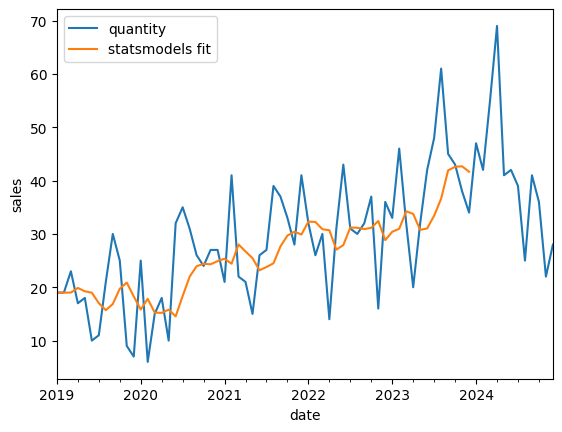

                                 ETS Results                                  
Dep. Variable:               quantity   No. Observations:                   60
Model:                       ETS(ANN)   Log Likelihood                -217.094
Date:                Sun, 13 Apr 2025   AIC                            438.188
Time:                        22:25:43   BIC                            442.377
Sample:                    01-01-2019   HQIC                           439.826
                         - 12-01-2023   Scale                           81.336
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.2180      0.092      2.366      0.018       0.037       0.399
              initialization method: known
------------------------------------------
initial_level                 

In [7]:
# Build and fit model
model = ETSModel(endog=df_train_one_d, 
                 error="add", trend=None, seasonal=None,
                 damped_trend=False, seasonal_periods=0,
                 initialization_method="known",
                 initial_level=19)

fit = model.fit()

# Plot
df.plot(label="data")
fit.fittedvalues.plot(label="statsmodels fit")
plt.ylabel("sales")
plt.legend()
plt.show()

print(fit.summary())
print(fit.params)
print(fit.fittedvalues)

# Grid Search
Find the best model using looping and compare the MAPE, lowest MAPE is the best model.

Tuning parameters: alpha, beta, gamma using a grid search.

## Model Evaluation without manual initial value and smoothing parameters value

In [37]:
# start find best model configurations

best_mape = float("inf")
best_config = None
y_pred = None


for config in valid_configs:
    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                try:
                    model = ETSModel(
                        endog=df_train_one_d, 
                        error=config["error"], 
                        trend=config["trend"], 
                        seasonal=config["seasonal"],
                        damped_trend=config["damped_trend"], 
                        seasonal_periods=12,
                        initialization_method="known",
                        initial_level=i_l,
                        initial_trend=i_t,
                        initial_seasonal=i_s_mul if config["seasonal"] == "mul" else i_s_add,
                    )

                    fit = model.fit(
                        start_params=[alpha, beta, gamma, alpha],
                    )
                    y_pred = fit.forecast(steps=12)

                    mape = mean_absolute_percentage_error(df_test_one_d, y_pred)

                    if mape < best_mape:
                        best_mape = mape
                        best_config = config

                except Exception as e:
                    print(f"Error with config {config}: {e}")
           

d:\ProgrammingProject\EstateMind\estatemind-prediction-service\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\ProgrammingProject\EstateMind\estatemind-prediction-service\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\ProgrammingProject\EstateMind\estatemind-prediction-service\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\ProgrammingProject\EstateMind\estatemind-prediction-service\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

Best config: {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True} with MAPE: 0.20083244581443105


<Figure size 1200x600 with 0 Axes>

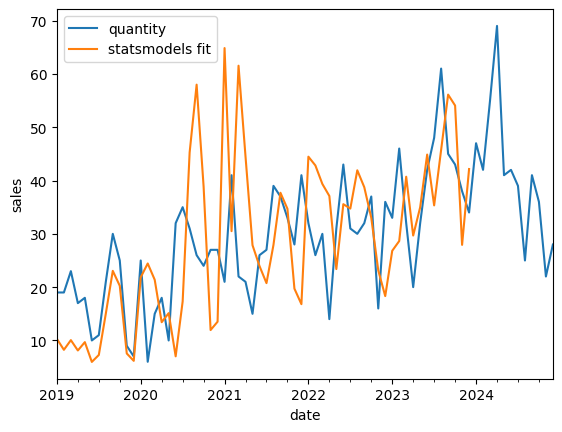

In [38]:
print(f"Best config: {best_config} with MAPE: {best_mape}")
# Plot the best model
plt.figure(figsize=(12, 6))
df.plot(label="data")
fit.fittedvalues.plot(label="statsmodels fit")
plt.ylabel("sales")
plt.legend()
plt.show()